# Retail Demo




In [6]:
from neo4j import GraphDatabase

# tag::imports[]
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# end::imports[]

In [39]:
bolt_uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(bolt_uri, auth=("neo4j", "letmein"))

print(driver.address)

localhost:7687


### Clean up Demo

In [40]:
run_queries = """

// Drop all models
CALL gds.beta.model.list()
YIELD modelInfo AS mInfo
WITH mInfo.modelName as savedModel
CALL gds.beta.model.drop(savedModel)
YIELD modelInfo
RETURN modelInfo;

// Drop all graphs
CALL gds.graph.list()
YIELD graphName AS namedGraph
WITH namedGraph
CALL gds.graph.drop(namedGraph)
YIELD graphName
RETURN graphName;

// REMOVE properties
MATCH (i:Item) REMOVE i.embedding;
MATCH (i:Item) REMOVE i.graphsage_embedding;
MATCH (i:Item) REMOVE i.node2vec_embedding;
MATCH (i:Item) REMOVE i.graphsage_embedding_everything;

// Delete extra OWLs
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item {Description:descr})
DETACH DELETE i;

// REMOVE extra similarity rels
UNWIND ['SIMILAR_EMBEDDING', 'SIMILAR_GRAPHSAGE_EMBEDDING_MULTIPARTITE','SIMILAR_GRAPHSAGE_EMBEDDING','SIMILAR_GRAPHSAGE_EMBEDDING_KNN', 'SIMILAR_NODE2VEC_EMBEDDING',
      'SIMILAR_EVERYTHING_EMBEDDING', 'Similar', 'SIMILAR'] as rel
MATCH ()-[r]->() WHERE type(r) = rel
DELETE r;   
"""


with driver.session() as session:
    for statement in run_queries.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

In [41]:
from neo4j import GraphDatabase, Query, unit_of_work
class Neo4j():
    """
    Neo4J db Interface class
    """
    def __init__(self, *args, **kwargs):
        url = kwargs.get('url', 'bolt://localhost:7687/')
        username = kwargs.get('username', 'neo4j')
        password = kwargs.get('password', 'neo4j12')
        database = kwargs.get('database', 'neo4j')
        self.client = GraphDatabase.driver(url, auth=(username, password), database=database)
    @unit_of_work(timeout=1200)
    def execute(self, tx, query):
        #return [row for row in tx.run(query)]
        return pd.DataFrame([dict(record) for record in tx.run(query)])
    def read(self, query):
        with self.client.session() as session:
            return session.read_transaction(self.execute, query)
    def write(self, query):
        with self.client.session() as session:
            return session.write_transaction(self.execute, query)

In [42]:
connection = {
        "url": "bolt://localhost:7687/",
        "username": "neo4j",
        "password": "letmein",
        "database": "neo4j"}
n = Neo4j(**connection)

### DB Schema

In [43]:
query = """
CALL db.schema.visualization;
"""
n.read(query)

,nodes,relationships
0,"[(name, indexes, constraints), (name, indexes,...","[(), (), (), (), (), ()]"


In [44]:
query = """
CALL apoc.meta.subGraph(
{excludes:['SIMILAR', 'SIMILAR_EMBEDDING', 'SIMILAR_EVERYTHING_EMBEDDING', 'SIMILAR_NODE2VEC_EMBEDDING', 'Similar']});
"""
n.read(query)


,nodes,relationships
0,"[(name, count), (name, count), (name, count), ...","[(count, type, in, out), (count, type, in, out..."


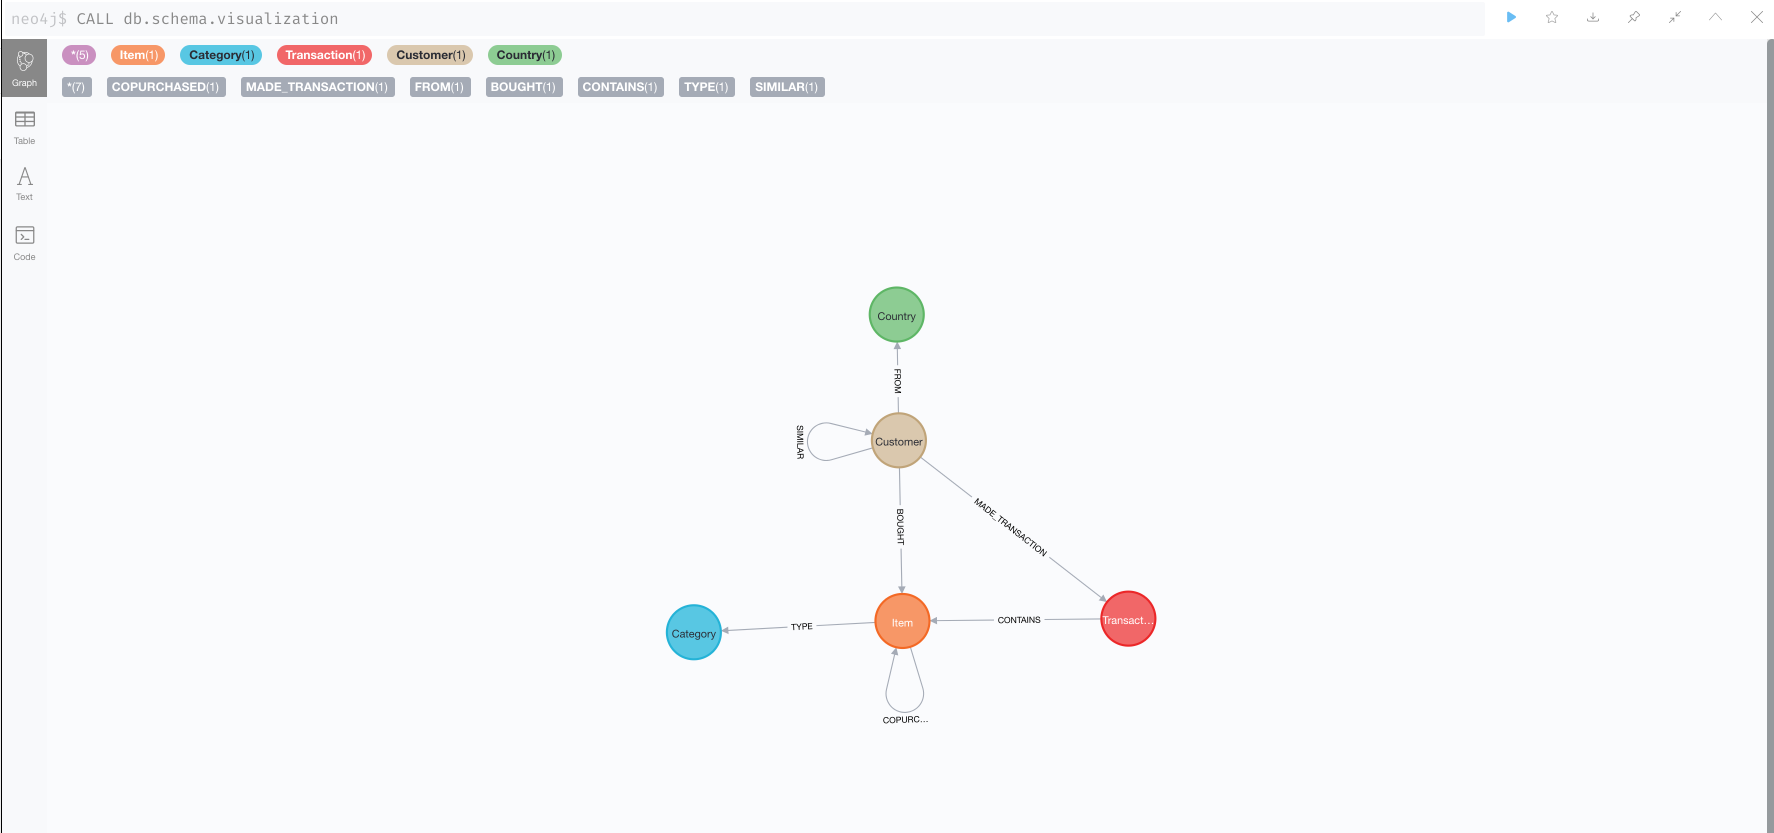

### Load Item Affinity Graph

https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/

https://en.wikipedia.org/wiki/Feature_scaling

In [45]:
query = """
CALL gds.graph.create(
  'items',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
         property: 'avg_price_scaled',
         defaultValue: 0
       },
       total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
      }
    }
  },
  {
      copurchased: {
        type: 'COPURCHASED',
      orientation: 'UNDIRECTED'
    }
  }
);
"""
n.read(query)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",items,2864,2430254,108


### **Node2Vec** on items Graph

In [16]:
query = """
CALL gds.alpha.node2vec.stream('items', {
     embeddingDimension: 8, 
     walkLength:16, 
     returnFactor: 1.0,
     inOutFactor:.5,
     concurrency:4});
"""
n.read(query)

,nodeId,embedding
0,12,"[0.35164129734039307, 0.28008192777633667, -0...."
1,13,"[-0.1126818060874939, 0.41576266288757324, -0...."
2,14,"[0.5460867881774902, 0.4070092439651489, -0.42..."
3,15,"[0.5138802528381348, 0.37255802750587463, -0.4..."
4,16,"[0.2924112379550934, 0.3237500488758087, -0.47..."
...,...,...
2859,2871,"[0.3707667291164398, 0.18680255115032196, -0.6..."
2860,2872,"[-0.7396333813667297, -0.08382133394479752, 0...."
2861,2873,"[0.5120095610618591, 0.4248706102371216, -0.42..."
2862,2874,"[-0.37678804993629456, -0.4322630763053894, -0..."


### **Node2Vec** write embeddings to graph

In [46]:
query = """
CALL gds.alpha.node2vec.write('items', 
    {
     embeddingDimension: 8, 
     walkLength:16, 
     returnFactor: 1.0,
     inOutFactor:.5,
     writeProperty:'node2vec_embedding',
     concurrency:4
    }
)
"""
n.write(query)

,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2864,2864,0,674615,41,"{'initialLearningRate': 0.025, 'writeConcurren..."


### **Calculate Similarity**

In [19]:
query = """
MATCH (i:Item)
 WITH {item:id(i), weights: i.node2vec_embedding} AS itemData
 WITH collect(itemData) AS data
 CALL gds.alpha.similarity.cosine.write({
  data: data,
  skipValue: null,
  topK: 5,
  similarityCutoff:.1,
  writeRelationshipType:'SIMILAR_NODE2VEC_EMBEDDING'
 })
YIELD min, max, mean, stdDev, p25, p50, p75, p90, p95, p99, p999, p100
RETURN min, max, mean, stdDev;
"""

n.write(query)

,min,max,mean,stdDev
0,0.730,0.999,0.960,0.051


# Bloom Demo
Recommend not only copurchased but also other simliar items based on similarity based on Node2Vec.

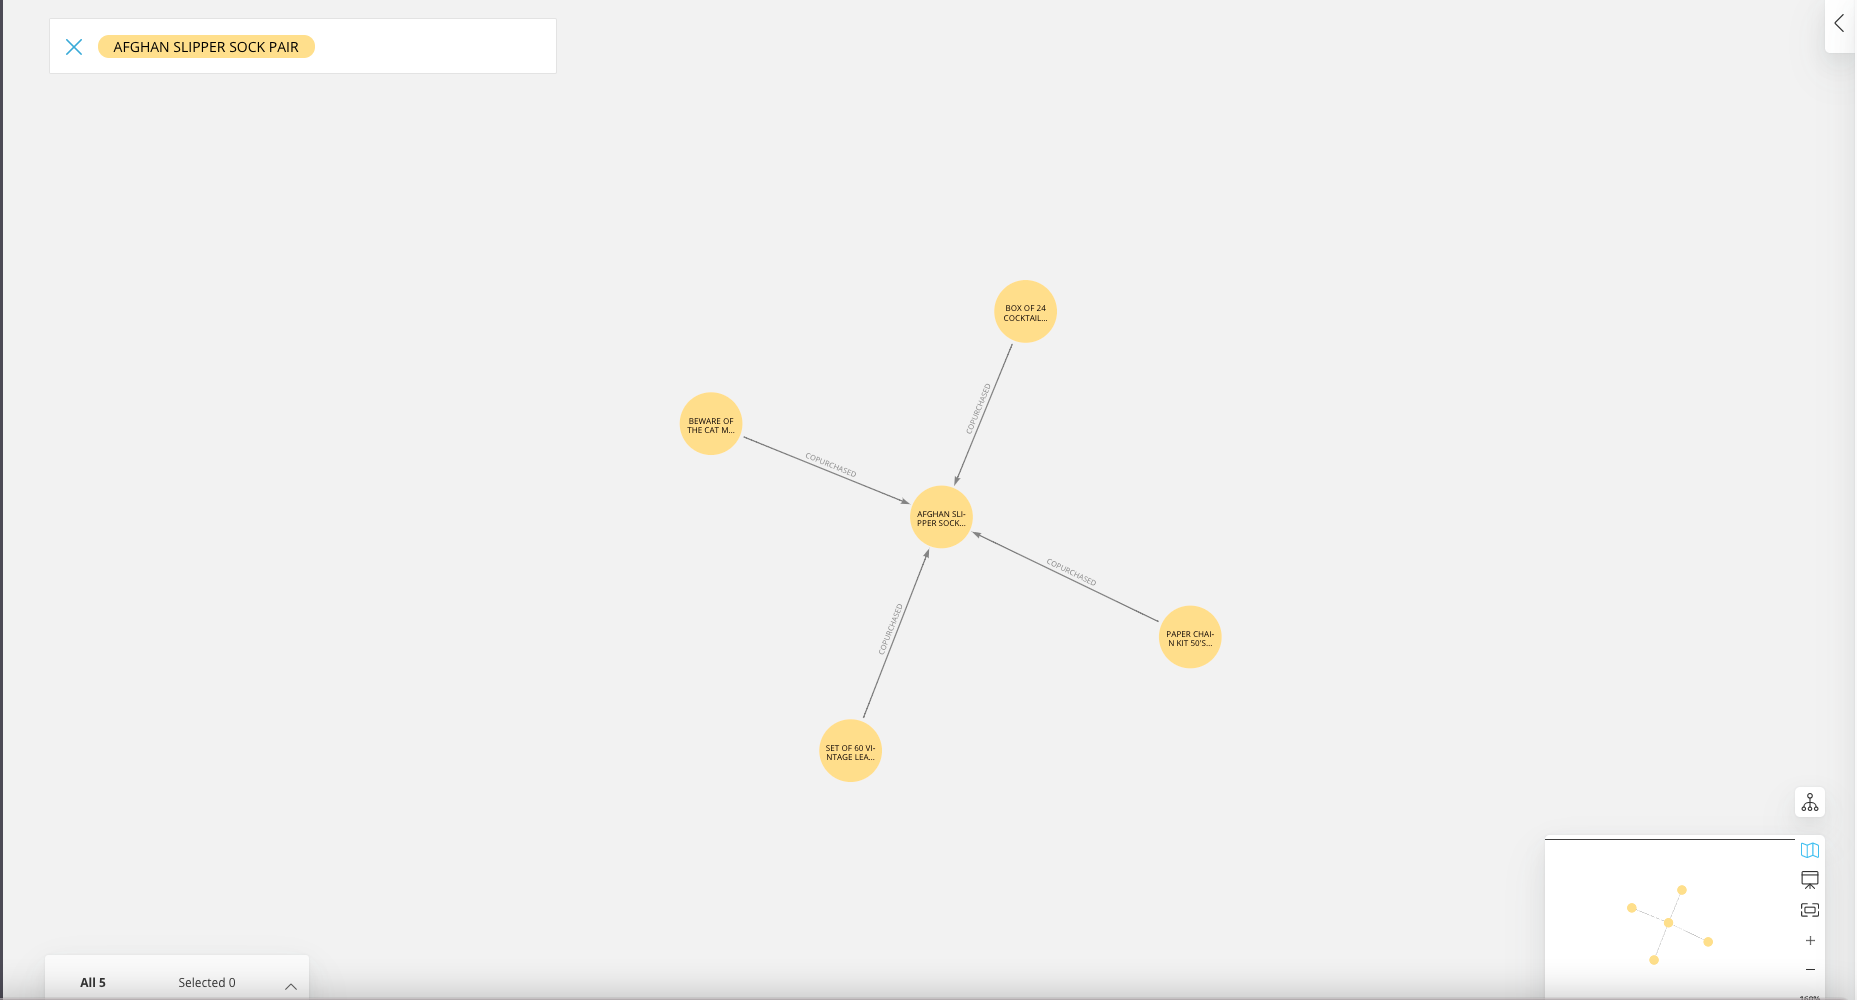

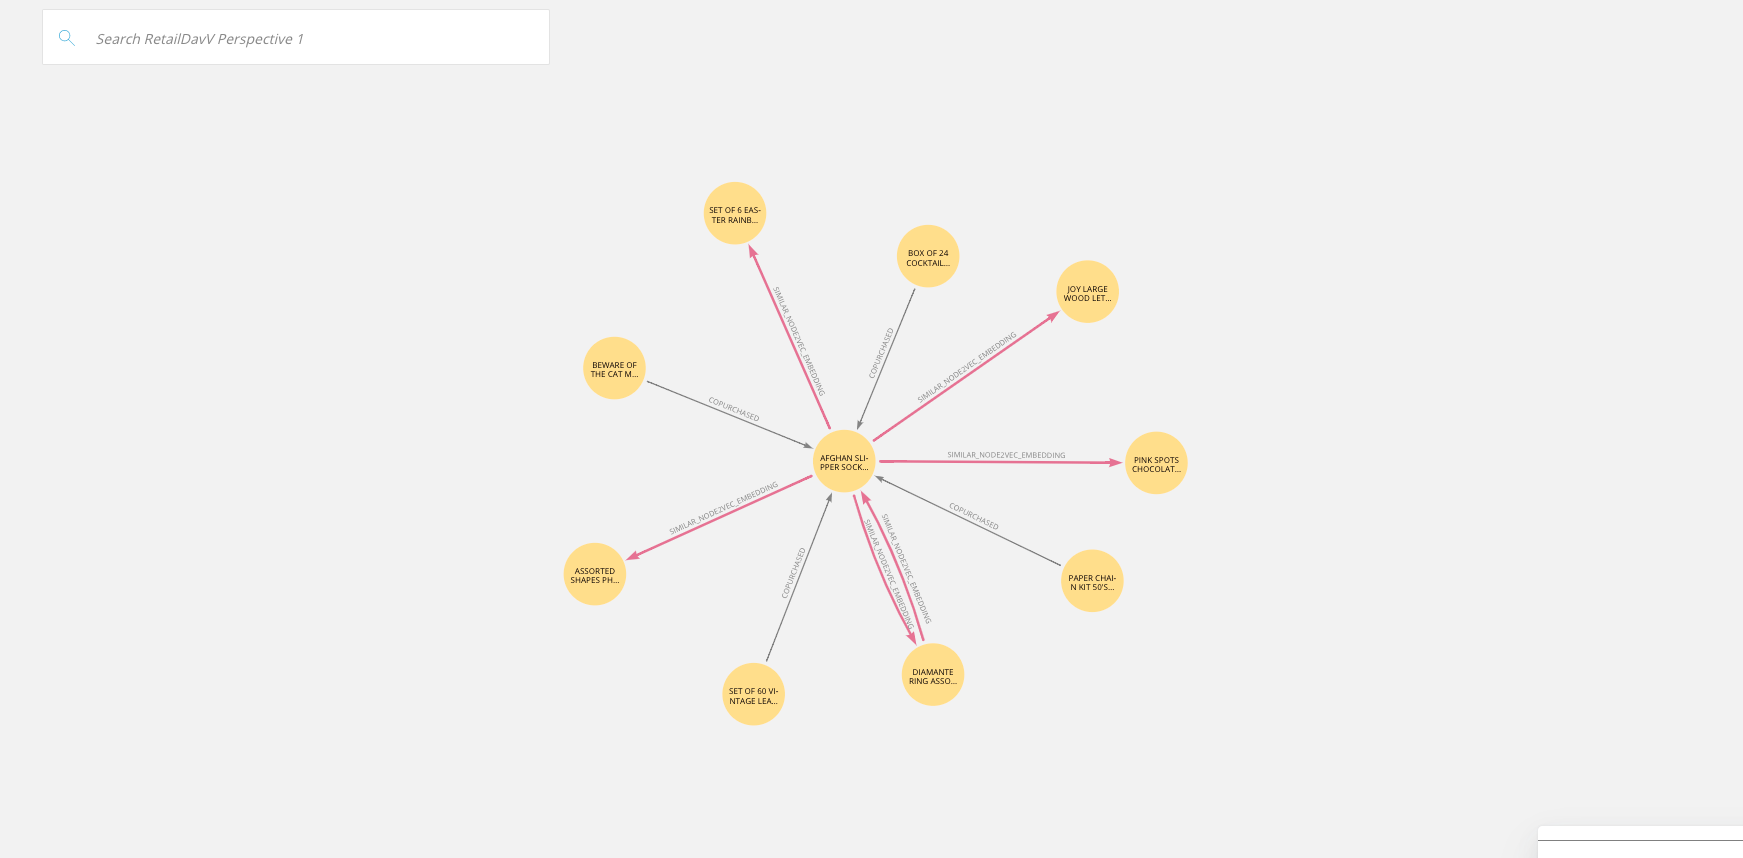

### **GraphSAGE** model training on items graph
GraphSAGE is an inductive algorithm for computing node embeddings. GraphSAGE is using node feature information to generate node embeddings on unseen nodes or graphs. Instead of training individual embeddings for each node, the algorithm learns a function that generates embeddings by sampling and aggregating features from a node’s local neighborhood.

https://towardsdatascience.com/inductive-vs-transductive-learning-e608e786f7d

https://neo4j.com/docs/graph-data-science/current/algorithms/graph-sage/

Node2Vec is a Transductive algorithm, so when you add new data you need to rerun it again for the complete data set, and it can take very long.
GraphSage is Inductive algorithm and we dont need to rerun it for the whole data set when you **add new items but we do need to refresh the affinity graph**.


In [20]:
## Drop if any models preexist, community edition allows only one
query = """
// Drop all models, commumity edition, allows one model only
CALL gds.beta.model.list()
YIELD modelInfo AS mInfo
WITH mInfo.modelName as savedModel
CALL gds.beta.model.drop(savedModel)
YIELD modelInfo
RETURN modelInfo;
"""
n.read(query)

""


In [21]:
query = """
CALL gds.beta.graphSage.train(
  'items',
  {
    embeddingDimension: 16,
    modelName: 'graphsage_demo',
    featureProperties: ['total_sold_scaled', 'price_scaled'],
    aggregator: 'pool', //aggregating data
    activationFunction: 'sigmoid', //part of the aggregation function
    degreeAsProperty: true, //adding more properties
    epochs: 5, //how many times to traverse the graph during training
    searchDepth:5, //depth of the random walk
    sampleSizes:[25,10], //how many nodes to sample at each layer
    negativeSampleWeight: 10 //used by the loss function
  }
);
"""

n.read(query)


,graphName,graphCreateConfig,modelInfo,configuration,trainMillis
0,items,{},"{'name': 'graphsage_demo', 'type': 'graphSage'}","{'maxIterations': 10, 'negativeSampleWeight': ...",25801


### **Add new data**

In [23]:
query = """
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item) where i.Description contains('SPACE OWL') WITH i, descr
CREATE (i2:Item{Description:descr})
CREATE (i) - [:COPURCHASED] -> (i2)
CREATE (i) <- [:COPURCHASED] - (i2);
"""

n.write(query)

""


### **Drop and Load affinity graph again**

In [24]:
query = """
CALL gds.graph.drop('items');
"""

n.read(query)

,graphName,database,memoryUsage,sizeInBytes,detailSizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,items,neo4j,3084 KiB,3158376,"{'relationships': {'total': 2908528, 'everythi...",{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",None,None,2864,2430254,0.296,2021-04-08T15:27:13.825869000,2021-04-08T15:27:14.005088000-04:00,"{'relationships': {'copurchased': {}}, 'nodes'..."


In [25]:
query = """
CALL gds.graph.create(
  'items',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
         property: 'avg_price_scaled',
         defaultValue: 0
       },
       total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
      }
    }
  },
  {
    copurchased: {
        type: 'COPURCHASED',
      orientation: 'UNDIRECTED'
    }
  }
);
"""

n.read(query)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",items,2869,2430274,222


### **Apply saved model to predict embeddings**

In [27]:
query = """
CALL gds.beta.graphSage.write(
  'items',
  {
    writeProperty:'graphsage_embedding',
    modelName: 'graphsage_demo'
  });
"""

n.write(query)


,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2869,2869,0,1886,96,"{'modelName': 'graphsage_demo', 'writeConcurre..."


### **Check embeddings for newly added data**

In [28]:
query = """
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item {Description:descr})
RETURN i.Description, i.graphsage_embedding;
"""

n.read(query)

,i.Description,i.graphsage_embedding
0,SEA OWL,"[1.3716692611300608e-12, 2.026266447771408e-09..."
1,LAND OWL,"[1.3716692611300608e-12, 2.026266447771408e-09..."
2,FIRE OWL,"[1.3716692611300608e-12, 2.026266447771408e-09..."
3,FOREST OWL,"[1.3716692611300608e-12, 2.026266447771408e-09..."
4,POTATO OWL,"[1.3716692611300608e-12, 2.026266447771408e-09..."


### **Calculate Similarity embedding**

In [30]:
query = """
 MATCH (i:Item)
 WITH {item:id(i), weights: i.graphsage_embedding} AS itemData
 WITH collect(itemData) AS data
 CALL gds.alpha.similarity.cosine.write({
  data: data,
  skipValue: null,
  topK: 5,
  similarityCutoff:.1,
  writeRelationshipType:'SIMILAR_GRAPHSAGE_EMBEDDING'
 })
YIELD min, max, mean, stdDev, p25, p50, p75, p90, p95, p99, p999, p100
RETURN min, max, mean, stdDev;
"""

n.write(query)

,min,max,mean,stdDev
0,0.999,1.000,1.000,0.000


## **GraphSAGE** multipartite graph

In [31]:
query = """
// Drop all graphs
CALL gds.graph.list()
YIELD graphName AS namedGraph
WITH namedGraph
CALL gds.graph.drop(namedGraph)
YIELD graphName
RETURN graphName;
"""

n.read(query)

,graphName
0,items


Item and Transactions

In [32]:
query = """
CALL gds.graph.create(
  'retail_graph',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
          property: 'avg_price_scaled',
          defaultValue: 0.0
        },
        total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
     }
    },
    Transaction: {
      label: 'Transaction',
      properties: {
       EpochTime:{
       	property:'EpochTime',
        defaultValue:0
       }
     }
    }

 
 }, {
    
    CONTAINS: {
      type: 'CONTAINS',
      orientation: 'UNDIRECTED'
    }
});
"""

n.read(query)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Transaction': {'properties': {'EpochTime': {...,"{'CONTAINS': {'orientation': 'UNDIRECTED', 'ag...",retail_graph,22718,944668,91


### Train a GraphSAGE model

In [33]:
query = """
// Drop all models, commumity edition, allows one model only
CALL gds.beta.model.list()
YIELD modelInfo AS mInfo
WITH mInfo.modelName as savedModel
CALL gds.beta.model.drop(savedModel)
YIELD modelInfo
RETURN modelInfo;
"""

n.read(query)

,modelInfo
0,"{'modelName': 'graphsage_demo', 'modelType': '..."


In [34]:
query = """
CALL gds.beta.graphSage.train(
  'retail_graph',
  {
    embeddingDimension: 8,
    modelName: 'graphsage_multipartite_demo',
    //which features should we use? all of them!
    featureProperties: ['price_scaled', 'EpochTime','total_sold_scaled'],
    //specify the projected feature dimension
    projectedFeatureDimension:5, //2 labels + 3 properties
    degreeAsProperty: true, //adding more properties
    epochs: 5, //how many times to traverse the graph during training
    searchDepth:5, //depth of the random walk,
    aggregator: 'mean', //aggregating data
    activationFunction: 'sigmoid', //part of the aggregation function
    sampleSizes:[25,10], //how many nodes to sample at each layer
    negativeSampleWeight: 10 //used by the loss function
  }
);
"""

n.read(query)

,graphName,graphCreateConfig,modelInfo,configuration,trainMillis
0,retail_graph,{},"{'name': 'graphsage_multipartite_demo', 'type'...","{'maxIterations': 10, 'negativeSampleWeight': ...",60652


### List model


In [35]:
query = """
CALL gds.beta.model.list()
YIELD modelInfo
RETURN modelInfo;
"""

n.read(query)

,modelInfo
0,"{'modelName': 'graphsage_multipartite_demo', '..."


### What are embeddings again?

In [36]:
query = """
CALL gds.beta.graphSage.stream(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo'
  });
"""

n.read(query)

,nodeId,embedding
0,12,"[0.9999656031416099, 1.8035657830135656e-08, 2..."
1,13,"[0.9999656031416099, 1.8035657830135656e-08, 2..."
2,14,"[0.9999656031416099, 1.8035657830135656e-08, 2..."
3,15,"[0.9999656031416099, 1.8035657830135656e-08, 2..."
4,16,"[0.9999656031416099, 1.8035657830135656e-08, 2..."
...,...,...
22713,27136,"[4.007000071018728e-06, 0.4472181925688924, 0...."
22714,27137,"[4.007000071018728e-06, 0.4472181925688924, 0...."
22715,27138,"[4.007000071018728e-06, 0.4472181925688924, 0...."
22716,27139,"[4.007000071018728e-06, 0.4472181925688924, 0...."


### **Mutate in-memory graph** - Add embeddings to the in-memory graph

In [37]:
query = """
CALL gds.beta.graphSage.mutate(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo',
    mutateProperty:'Embedding'
  });
"""

n.write(query)

,nodePropertiesWritten,mutateMillis,nodeCount,createMillis,computeMillis,configuration
0,22718,2,22718,0,6836,"{'modelName': 'graphsage_multipartite_demo', '..."


### **Write Similarity Property to graph using KNN**

In [38]:
query = """
CALL gds.beta.knn.write('retail_graph', {
    writeRelationshipType: 'SIMILAR_GRAPHSAGE_EMBEDDING_MULTIPARTITE',
    writeProperty: 'score',
    topK: 5,
    randomSeed: 42,
    nodeWeightProperty: 'Embedding'
})
YIELD nodesCompared, relationshipsWritten;
"""

n.write(query)

,nodesCompared,relationshipsWritten
0,22718,46184
